In [1]:
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import pymc.sampling_jax
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_score, recall_score, roc_auc_score, accuracy_score, auc
from sklearn.calibration import CalibrationDisplay
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

%load_ext watermark
%watermark -n -u -v -iv -w -p sklearn

Last updated: Tue Jun 11 2024

Python implementation: CPython
Python version       : 3.9.18
IPython version      : 8.12.0

sklearn: 1.4.0

numpy     : 1.26.3
pytensor  : 2.18.6
seaborn   : 0.13.2
matplotlib: 3.8.2
arviz     : 0.17.0
pandas    : 2.2.0
pymc      : 5.10.3

Watermark: 2.4.3



In [2]:
import os

os.chdir("D:/Transmission_probability_v2/method3_enveloppes/v_PyMC/")

In [3]:
df = pd.read_excel("Input/v_minutes/under_2m/enveloppe1_0.1_pivot.xlsx")
df1 = pd.read_excel("Input/v_minutes/under_2m/enveloppe1_0.1.xlsx")
y = df1["infected"].to_numpy()

In [4]:
df.head()

,experiment,contact_duration,cap_ID,infected,distance,time
0,1,1,100,0,1.427346,2
1,1,1,100,0,0.978005,2
2,1,1,100,0,0.974849,1
3,1,1,100,0,1.791249,1
4,1,1,100,0,1.298035,1


## Exploratory data analysis

In [5]:
df1['infected'].value_counts()

infected
0    48
1    16
Name: count, dtype: int64

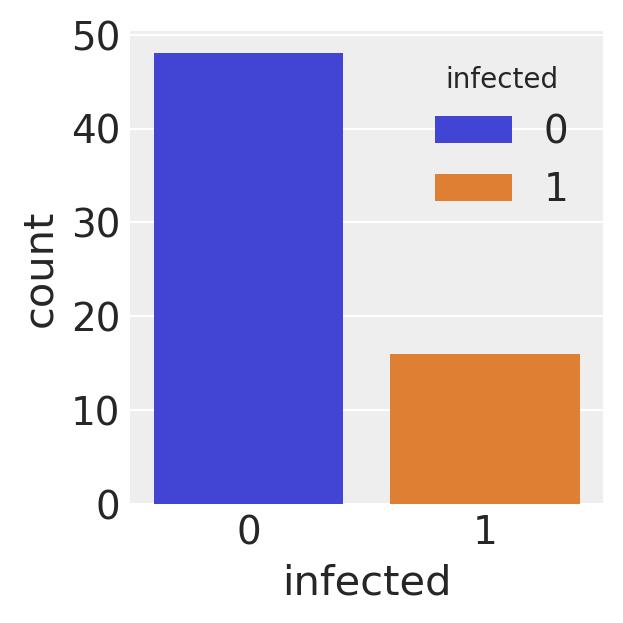

In [6]:
ax = plt.figure(figsize=(3,3))
ax = sns.countplot(x='infected', data=df1, hue='infected', stat='count');

In [7]:
# Pre-calculate unique combinations of experiment and contact_duration
unique_combinations = df[['experiment', 'contact_duration', 'cap_ID']].drop_duplicates()

# Convert to a list of tuples for iteration
unique_combinations = [tuple(x) for x in unique_combinations.to_numpy()]

In [8]:
distances_list = []
times_list = []

for e, c, i in unique_combinations:
    df_temp = df[(df['experiment'] == e) & (df['contact_duration'] == c) & (df['cap_ID'] == i)]
    distances = df_temp['distance'].values
    times = df_temp['time'].values
    distances_list.append(distances)
    times_list.append(times)

# Convertir les listes en matrices numpy de type object
distances_matrix = np.array(distances_list, dtype=object)
times_matrix = np.array(times_list, dtype=object)

In [10]:
distances_matrix[0]

array([1.42734612, 0.9780052 , 0.97484892, 1.79124862, 1.29803524,
       0.63244417, 1.5794651 , 0.76886465, 1.92701445, 1.70439828,
       1.82306076, 0.92464724, 1.75740863, 1.10752691, 1.57112972,
       1.31189853, 1.49677701, 1.75991431, 0.6023953 , 1.40261975,
       1.95991046, 1.38360175, 1.03232724, 1.73981587, 0.56704535,
       1.30770034, 1.93761446, 1.18172526, 1.95342292, 1.58338978,
       1.69418178, 0.90315029, 1.08265868, 1.34406378])

In [11]:
times_matrix[0].sum()

36

In [22]:
time_covered = []
for i in range(len(times_matrix)):
    time_covered.append(times_matrix[i].sum())

new_df = df1.iloc[:, :3].copy()

# Add the time_covered list to a new column
new_df['time_covered'] = time_covered

new_df.head()

#new_df.to_csv("Output/under_2m/full_time_envelope/enveloppe1_0.1_time_covered_2m.csv", index=False)

In [18]:
with pm.Model() as model:
    # Priors
    p0 = pm.Beta('p0', alpha=1, beta=1)
    lambda_ = pm.LogNormal('lambda', mu=-1, sigma=0.1)
    
    # Calcul vectorisé avec objets numpy de type `object`
    p_temp_list = [(1 - (p0 * pt.exp(-lambda_ * dist))) ** time for dist, time in zip(distances_matrix, times_matrix)]
    p_prod = pt.stack([pt.prod(p_temp) for p_temp in p_temp_list])
    p_list = 1 - p_prod

    p_list_det = pm.Deterministic('p_list', p_list)

    # Likelihood
    y_true = pm.Bernoulli('y_obs', p=p_list, observed=y)

    inits = {'p0': 0.001, 'lambda': 0.1}

In [19]:
# %%time
# with model:
#     trace = pm.sampling.jax.sample_blackjax_nuts(draws=10000, tune=1000, chains=10, target_accept=0.95, initvals=inits, random_seed=42)

Compiling...
Compilation time = 0:00:26.900008
Sampling...
Sampling time = 0:02:10.399872
Transforming variables...
Transformation time = 0:00:17.930231


CPU times: total: 4min 24s
Wall time: 2min 55s


In [20]:
# with open('Output/under_2m/traces/trace_enveloppe_2m_0.1.pkl', 'wb') as f:
#     pickle.dump(trace, f)

In [24]:
with open('Output/under_2m/traces/trace_enveloppe_2m_0.1.pkl', 'rb') as f:
    trace = pickle.load(f)

In [25]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

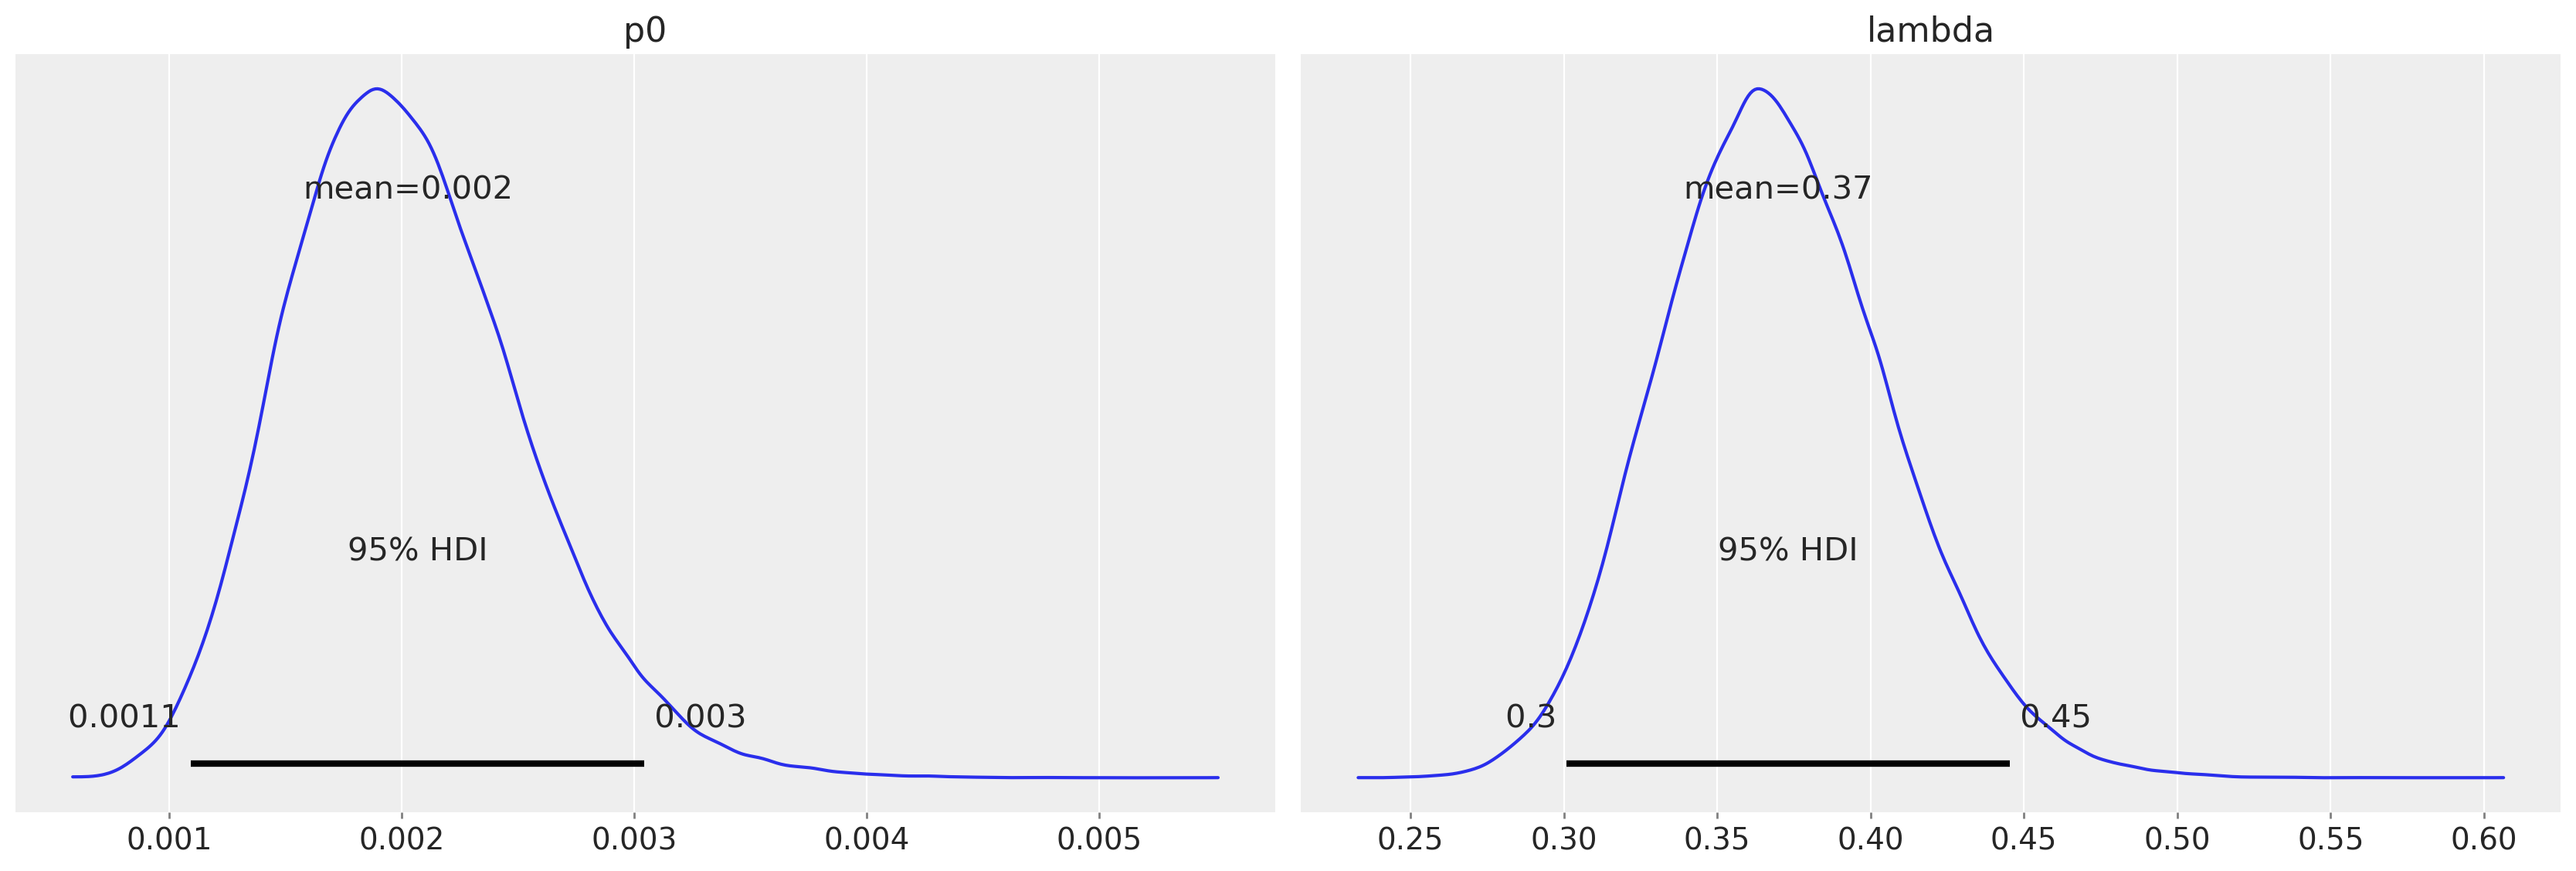

In [26]:
az.plot_posterior(trace, var_names=["p0", "lambda"], hdi_prob=.95);

In [27]:
az.plot_posterior(trace, var_names=["p_list"], hdi_prob=.95);

c:\Users\U117-T408\anaconda3\envs\tf\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (64) in plot_posterior, generating only 40 plots
  warnings.warn(


In [31]:
trace_summary = az.summary(trace, round_to = 4, hdi_prob=.95)

#trace_summary.to_csv("Output/under_2m/trace_summary/trace_summary_enveloppe_2m_0.1.csv")

trace_summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p0,0.0020,0.0005,0.0011,0.0030,0.0000,0.0000,60750.1213,54918.7047,1.0002
lambda,0.3698,0.0371,0.3010,0.4454,0.0002,0.0001,60735.8119,59640.8184,1.0001
p_list[0],0.0436,0.0105,0.0241,0.0645,0.0000,0.0000,63754.2820,55630.6356,1.0001
p_list[1],0.0665,0.0158,0.0371,0.0980,0.0001,0.0000,63458.3230,55409.8012,1.0001
p_list[2],0.0713,0.0169,0.0399,0.1050,0.0001,0.0000,63254.6267,55264.0772,1.0001
...,...,...,...,...,...,...,...,...,...
p_list[59],0.1376,0.0313,0.0794,0.2005,0.0001,0.0001,63977.0135,55682.6725,1.0001
p_list[60],0.0654,0.0156,0.0360,0.0959,0.0001,0.0000,64594.3679,55930.5641,1.0001
p_list[61],0.1911,0.0420,0.1118,0.2746,0.0002,0.0001,63839.3731,55669.8637,1.0001
p_list[62],0.3569,0.0692,0.2220,0.4915,0.0003,0.0002,62973.8228,55212.9335,1.0002


In [34]:
# extract samples from the trace
samples = trace.posterior.stack(sample=("chain", "draw"))

# # select a random sample from the trace
# selected_samples = np.random.choice(range(len(samples['p0'])), size=2, replace=False)

# # extract the values of the parameters
# p0_sample = samples['p0'].values[selected_samples]
# lambda_sample = samples['lambda'].values[selected_samples]

# extract the values of the estimated probabilities
p_list_df = pd.DataFrame(samples['p_list'].values)

# p_list_sample = p_list_df.sample(n=5000, axis=1)
# p_list_sample


p_list_df.head()

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
0,0.042424,0.049986,0.049697,0.029813,0.041911,0.043426,0.034599,0.033854,0.041151,0.053154,...,0.047181,0.033730,0.047287,0.046801,0.050917,0.035780,0.049820,0.037467,0.037321,0.042017
1,0.064496,0.076123,0.075038,0.045610,0.063768,0.065837,0.053505,0.051900,0.062574,0.080778,...,0.071930,0.051320,0.072073,0.071225,0.077252,0.054639,0.076190,0.057670,0.057482,0.064089
2,0.068954,0.081560,0.079924,0.048891,0.068209,0.070261,0.057802,0.055741,0.066898,0.086462,...,0.077098,0.054832,0.077238,0.076246,0.082570,0.058544,0.081863,0.062132,0.061956,0.068670
3,0.073979,0.088046,0.084991,0.052757,0.073267,0.075046,0.063716,0.060471,0.071760,0.093117,...,0.083291,0.058694,0.083408,0.082100,0.088589,0.063128,0.089029,0.067994,0.067877,0.074088
4,0.007276,0.008483,0.008700,0.005034,0.007169,0.007518,0.005600,0.005661,0.007057,0.009073,...,0.007988,0.005797,0.008013,0.007977,0.008754,0.006061,0.008325,0.006160,0.006122,0.007122


In [35]:
p_list_df.columns = p_list_df.add_prefix('prob_').columns

concatenated_cols = pd.concat([df1["experiment"], df1["contact_duration"], df1["infected"]], axis=1)
p_list_df_concat = pd.concat([concatenated_cols, p_list_df], axis=1)

p_list_df_concat = p_list_df_concat.reset_index().drop(columns='index')

p_list_df_concat.head()

,experiment,contact_duration,infected,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,...,prob_99990,prob_99991,prob_99992,prob_99993,prob_99994,prob_99995,prob_99996,prob_99997,prob_99998,prob_99999
0,1,1,0,0.042424,0.049986,0.049697,0.029813,0.041911,0.043426,0.034599,...,0.047181,0.033730,0.047287,0.046801,0.050917,0.035780,0.049820,0.037467,0.037321,0.042017
1,1,1,0,0.064496,0.076123,0.075038,0.045610,0.063768,0.065837,0.053505,...,0.071930,0.051320,0.072073,0.071225,0.077252,0.054639,0.076190,0.057670,0.057482,0.064089
2,1,1,0,0.068954,0.081560,0.079924,0.048891,0.068209,0.070261,0.057802,...,0.077098,0.054832,0.077238,0.076246,0.082570,0.058544,0.081863,0.062132,0.061956,0.068670
3,1,1,0,0.073979,0.088046,0.084991,0.052757,0.073267,0.075046,0.063716,...,0.083291,0.058694,0.083408,0.082100,0.088589,0.063128,0.089029,0.067994,0.067877,0.074088
4,1,1,0,0.007276,0.008483,0.008700,0.005034,0.007169,0.007518,0.005600,...,0.007988,0.005797,0.008013,0.007977,0.008754,0.006061,0.008325,0.006160,0.006122,0.007122


In [36]:
means = round(p_list_df.apply(np.mean, axis=1), 4)
medians = round(p_list_df.apply(np.median, axis=1), 4)
sd = round(p_list_df.apply(np.std, axis=1), 4)
percentile_2 = round(p_list_df.apply(lambda x: np.percentile(x, 2.5), axis=1),4)
percentile_25 = round(p_list_df.apply(lambda x: np.percentile(x, 25), axis=1),4)
percentile_75 = round(p_list_df.apply(lambda x: np.percentile(x, 75), axis=1), 4)
percentile_97 = round(p_list_df.apply(lambda x: np.percentile(x, 97.5), axis=1), 4)

# Create a DataFrame with the results   
ID_probs_summary = pd.DataFrame({'mean': means, 'sd': sd, 'median': medians, '2.5%': percentile_2, '25%': percentile_25, '75%': percentile_75, '97.5%': percentile_97})
ID_probs_summary_concat = pd.concat([concatenated_cols, ID_probs_summary], axis=1)
ID_probs_summary_concat = ID_probs_summary_concat.reset_index().drop(columns='index')
ID_probs_summary_concat

,experiment,contact_duration,infected,mean,sd,median,2.5%,25%,75%,97.5%
0,1,1,0,0.0436,0.0105,0.0429,0.0254,0.0361,0.0503,0.0662
1,1,1,0,0.0665,0.0158,0.0654,0.0389,0.0553,0.0766,0.1004
2,1,1,0,0.0713,0.0169,0.0702,0.0417,0.0593,0.0820,0.1076
3,1,1,0,0.0771,0.0182,0.0758,0.0452,0.0641,0.0887,0.1162
4,1,1,0,0.0074,0.0018,0.0072,0.0042,0.0061,0.0085,0.0113
...,...,...,...,...,...,...,...,...,...,...
59,6,8,0,0.1376,0.0313,0.1356,0.0819,0.1153,0.1577,0.2038
60,6,8,0,0.0654,0.0156,0.0642,0.0382,0.0542,0.0752,0.0988
61,6,8,0,0.1911,0.0420,0.1888,0.1155,0.1613,0.2184,0.2790
62,6,8,0,0.3569,0.0692,0.3551,0.2268,0.3083,0.4033,0.4968


In [37]:
# Bernoulli draws from the estimated probabilities

simulations_bernoulli = p_list_df.map(lambda prob: np.random.binomial(1, prob))

In [38]:
simulations_bernoulli.head()

,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,prob_7,prob_8,prob_9,...,prob_99990,prob_99991,prob_99992,prob_99993,prob_99994,prob_99995,prob_99996,prob_99997,prob_99998,prob_99999
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
final_outcomes_majority = simulations_bernoulli.mode(axis=1)[0].astype(int)
final_outcomes_majority = pd.concat([concatenated_cols, final_outcomes_majority], axis=1)

final_outcomes_majority = final_outcomes_majority.reset_index().drop(columns='index')

final_outcomes_majority = final_outcomes_majority.rename(columns={0: 'estimated_class'})

final_outcomes_majority.head()

,experiment,contact_duration,infected,estimated_class
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,1,0,0


In [50]:
concatenated_cols = pd.concat([df1["experiment"], df1["contact_duration"], df1["infected"]], axis=1)
concatenated_df = pd.concat([concatenated_cols, simulations_bernoulli], axis=1)

concatenated_df = concatenated_df.reset_index().drop(columns='index')

concatenated_df.head()

,experiment,contact_duration,infected,prob_0,prob_1,prob_2,prob_3,prob_4,prob_5,prob_6,...,prob_99990,prob_99991,prob_99992,prob_99993,prob_99994,prob_99995,prob_99996,prob_99997,prob_99998,prob_99999
0,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
cases_per_exp = concatenated_df.groupby(['experiment', 'contact_duration']).sum().reset_index()

N = [6, 6, 6 , 6, 6, 5, 6,5, 6, 6, 6]

cases_per_exp.insert(2, 'N', N)

cases_per_exp = cases_per_exp.rename(columns={'infected': 'positives'})

cases_per_exp.to_csv('Output/under_2m/cases_per_experiment/cases_per_experiment_enveloppe_2m.csv', index=False)

In [55]:
proportions = simulations_bernoulli.mean(axis=1)
df_proportions = pd.DataFrame(proportions, columns=['y_pred'])
df_proportions.insert(0, 'y_true', y)
p_list_df.insert(0, 'y_true', y)

ValueError: cannot insert y_true, already exists

In [56]:
y_true = df_proportions['y_true']
y_pred = df_proportions['y_pred']

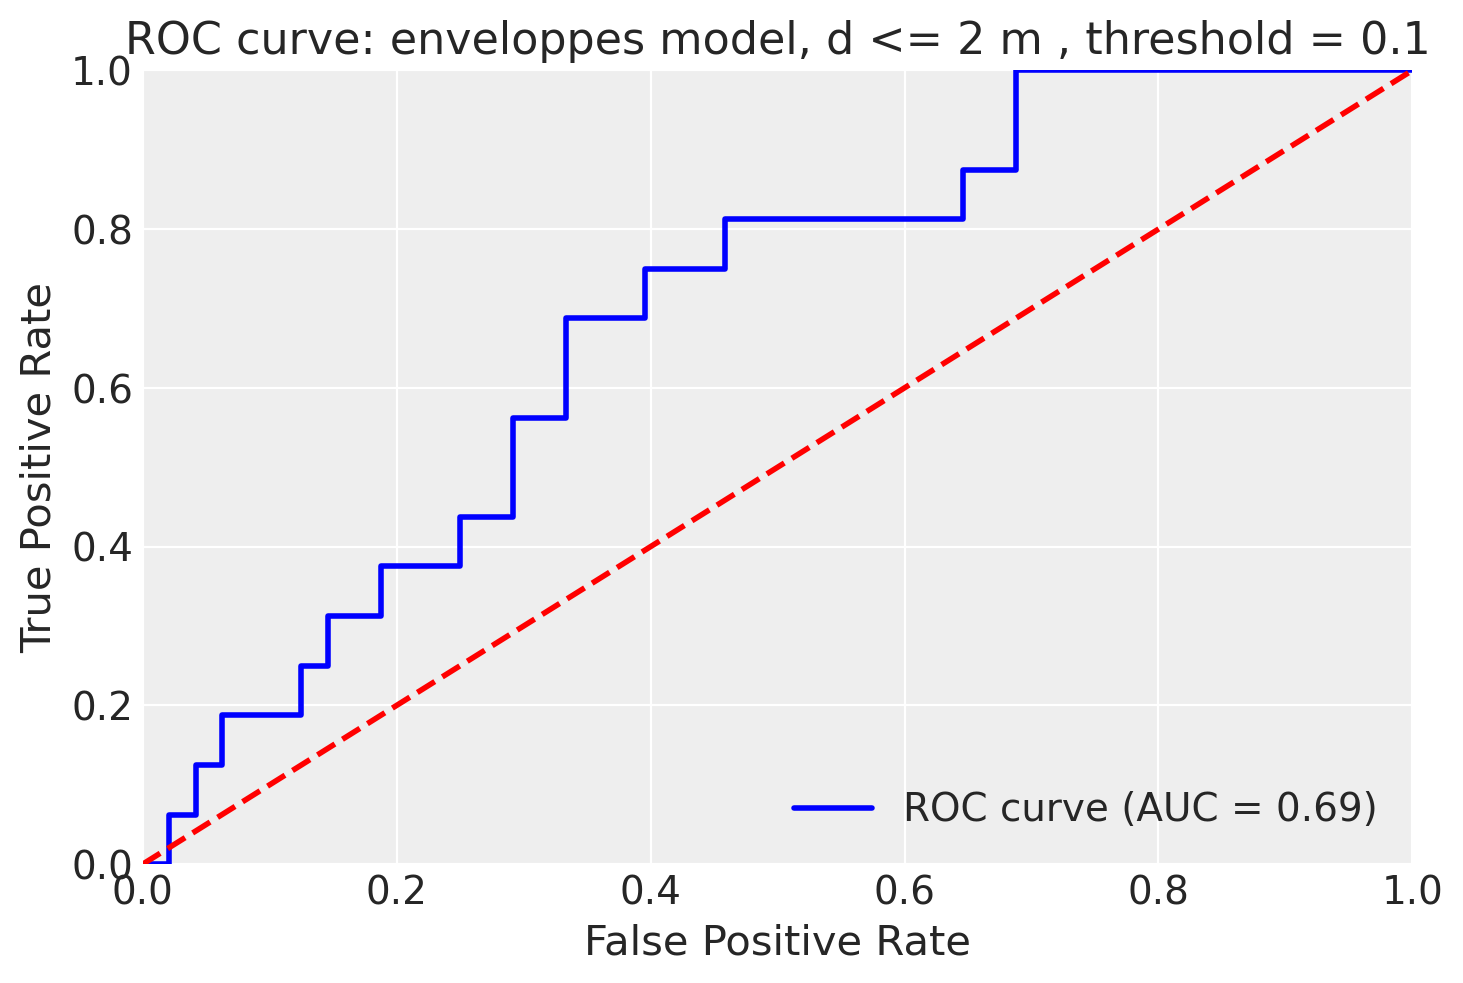

In [77]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: enveloppes model, d <= 2 m , threshold = 0.1')
plt.legend(loc="lower right")
plt.savefig('Output/under_2m/figures/ROC_Curve_enveloppe_2m_0.1.png')
plt.show()


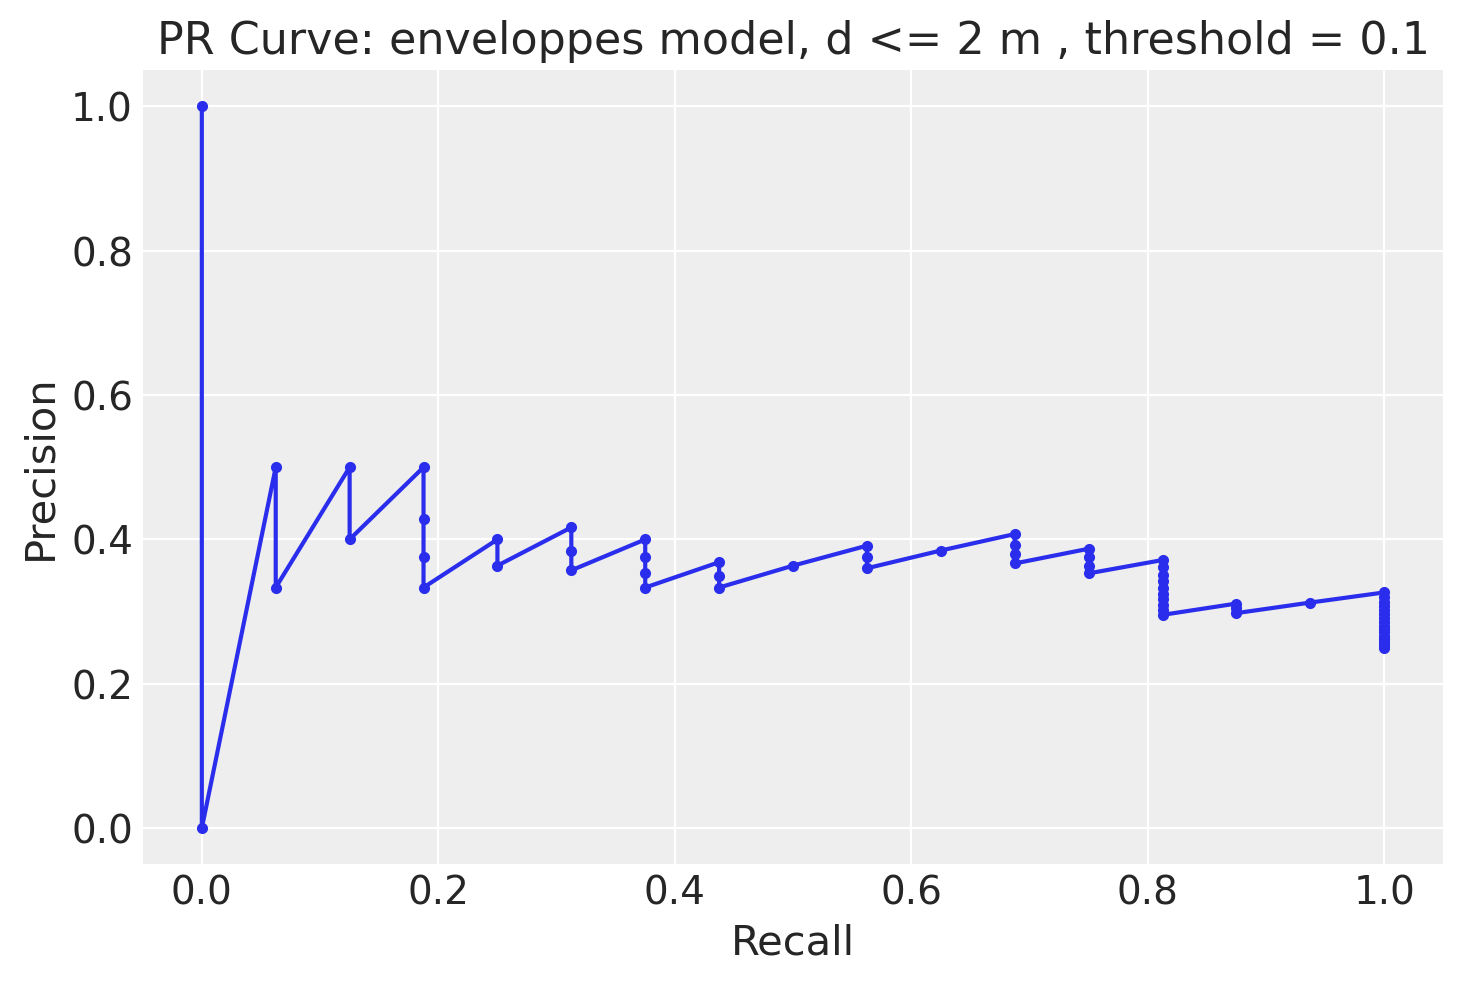

In [75]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve: enveloppes model, d <= 2 m , threshold = 0.1')
plt.savefig('Output/under_2m/figures/PR_Curve_enveloppe_2m_0.1.png')
plt.show()

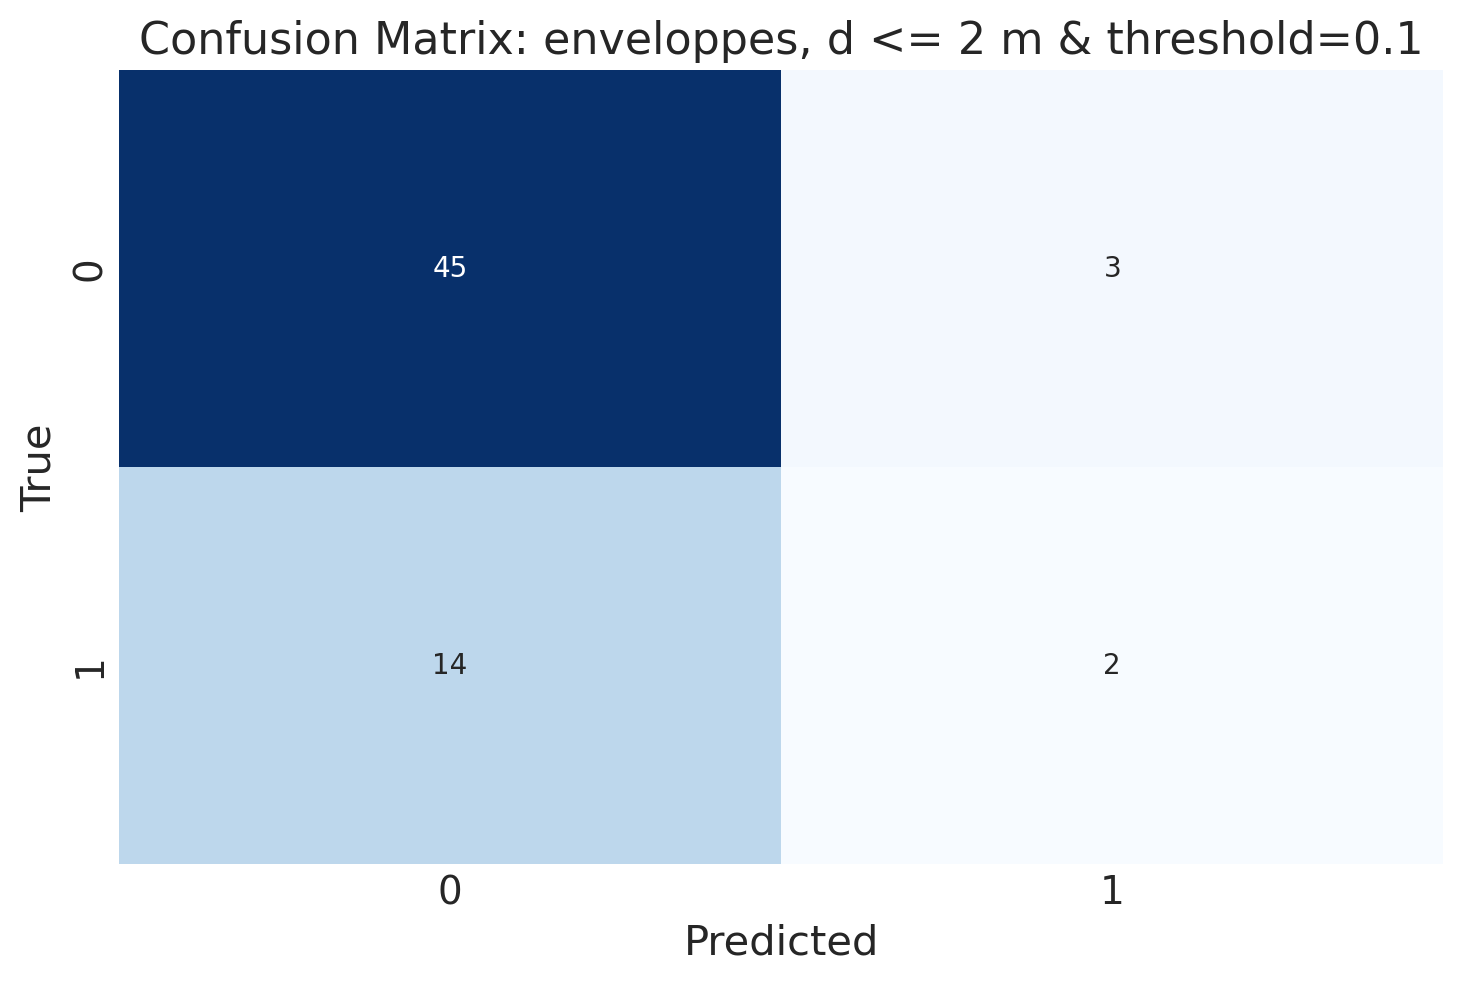

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Convert probabilities to binary predictions
y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]

# Now you can compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_binary)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: enveloppes, d <= 2 m & threshold=0.1')
plt.savefig('Output/under_2m/figures/confusion_matrix_enveloppe_2m_0.1.png')
plt.show()


In [ ]:
df1['animal_ID'] = df1['experiment'].astype(str) + '_' + df1['contact_duration'].astype(str) + '_' + df1['cap_ID'].astype(str)

In [ ]:
df_proportions.insert(0, 'animal_ID', df1['animal_ID'])

In [ ]:
df_proportions.sort_values(by=['y_true', 'animal_ID'], ascending= True, inplace=True)
df_proportions.to_excel('Output2/df_proportions_2m_0.1.xlsx', index=False)

In [ ]:
df_proportions = pd.read_excel("Output2/df_proportions_2m_0.1.xlsx")

In [ ]:
# Créer une figure et un axe
fig, ax = plt.subplots(figsize = (20, 8))

# Tracer les points pour y_true et y_pred
ax.scatter(df_proportions['animal_ID'], df_proportions['y_true'], color='blue', label='Real observations')
ax.scatter(df_proportions['animal_ID'],df_proportions['y_pred'], color='red', label='Predicted probabilities')
ax.plot(df_proportions['animal_ID'], df_proportions['y_pred'], color='red')
ax.axhline(0.5, color='gray', lw=2, linestyle='--', label= 'y_pred=0.5')

# Tracer les boîtes entre y_true et y_pred
for i in range(len(df_proportions)):
    ax.plot([df_proportions['animal_ID'].iloc[i]]*2, [df_proportions['y_true'].iloc[i], df_proportions['y_pred'].iloc[i]], color='black')

# Définir les limites de l'axe des y
ax.set_ylim([0, 1])

for label in ax.get_xticklabels():
    label.set_rotation(90)

# Ajouter une légende
ax.legend()
plt.title("Real VS Predicted: enveloppes model, distance <= 2 m, threshold=0.1")
plt.xlabel("Animal Identifier")

plt.show()

In [ ]:
def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    auc = roc_auc_score(true_y, y_prob)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:0.4f})')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: enveloppes 2m , seuil = 0.1')
    plt.legend(loc="lower right")

In [ ]:
aucs = []

# Boucle sur chaque colonne d'estimations
for col in simulations_proba.columns[1:] : # Commencer à partir de la deuxième colonne car la première est y_true
    y_pred = simulations_proba[col]
    auc = roc_auc_score(y_true, y_pred)
    aucs.append(auc)


In [ ]:
mean_auc = np.mean(aucs)
median_auc = np.median(aucs)

print("mean auc:", mean_auc)
print("median auc:", median_auc)

q1 = np.quantile(aucs, 0.25)
q3 = np.quantile(aucs, 0.75)

if q3 == q1: 
   print("Not enough data")
else:
   iqr = q3 - q1  
   lower = q1 - 1.5 * iqr
   upper = q3 + 1.5 * iqr 
   conf_interval = (lower, upper)

   print(conf_interval)

In [ ]:
# Trouver l'indice du maximum dans la liste d'AUC
indice_max_auc = np.argmax(aucs)

# Récupérer la colonne d'estimation avec le maximum d'AUC
col_max_auc = simulations_proba.columns[indice_max_auc + 1]  # +1 pour compenser la première colonne (y_true)

# Afficher la colonne d'estimation avec le maximum d'AUC
print(f"La colonne avec le maximum d'AUC est : {col_max_auc}")

In [ ]:
y_pred = simulations_proba['y_pred342']

In [ ]:
plot_roc_curve(y_true, y_pred)

In [ ]:
# Plot histogram  
plt.hist(y_true, bins=30, density=True)
plt.hist(y_pred, bins=30, density=True)
plt.vlines(y_pred.mean(), 0, 0.4, colors='r') 

plt.xlabel('Sampled θ')  
plt.ylabel('Density')
plt.title('Real vs Predicted : enveloppes 2m , seuil = 0.1 ')
   
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_true, y_pred > 0.5) 
print(accuracy)

In [ ]:
from sklearn.metrics import precision_score, recall_score  

precision = precision_score(y_true, y_pred > 0.5)  
recall = recall_score(y_true, y_pred > 0.5)

print(precision, recall)

In [ ]:
from sklearn.calibration import CalibrationDisplay

CalibrationDisplay.from_predictions(y_true, y_pred)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

specificity = 1 - fpr
plt.plot(specificity, tpr, color='green', label='Sensitivity')
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Sensitivity/Specificity Curve')
plt.legend(loc="lower right")
plt.show()

# Posterior analysis

In [ ]:
az.plot_trace(trace, combined=True);

In [ ]:
az.summary(trace, round_to=6)

In [ ]:
pm.model_to_graphviz(model)

In [ ]:
az.plot_energy(trace);

# Model log-likelihood

In [60]:
with model:
    pm.compute_log_likelihood(trace)

In [61]:
model_loo = az.loo(trace)

model_loo

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -35.16     4.75
p_loo        1.17        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       64  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [62]:
model_waic = az.waic(trace)

model_waic

Computed from 100000 posterior samples and 64 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -35.16     4.75
p_waic        1.17        -

In [63]:
# Generate posterior predictive samples
with model:
    pm.sample_posterior_predictive(trace, random_seed=42, extend_inferencedata=True)

Sampling: [y_obs]


In [64]:
trace.posterior_predictive

<xarray.Dataset>
Dimensions:      (chain: 10, draw: 10000, y_obs_dim_2: 64)
Coordinates:
  * chain        (chain) int32 0 1 2 3 4 5 6 7 8 9
  * draw         (draw) int32 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * y_obs_dim_2  (y_obs_dim_2) int32 0 1 2 3 4 5 6 7 ... 56 57 58 59 60 61 62 63
Data variables:
    y_obs        (chain, draw, y_obs_dim_2) int64 0 0 0 0 0 0 1 ... 1 0 0 0 0 0
Attributes:
    created_at:                 2024-06-11T09:05:18.179722
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.3

c:\Users\U117-T408\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
c:\Users\U117-T408\anaconda3\envs\tf\lib\site-packages\arviz\plots\ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


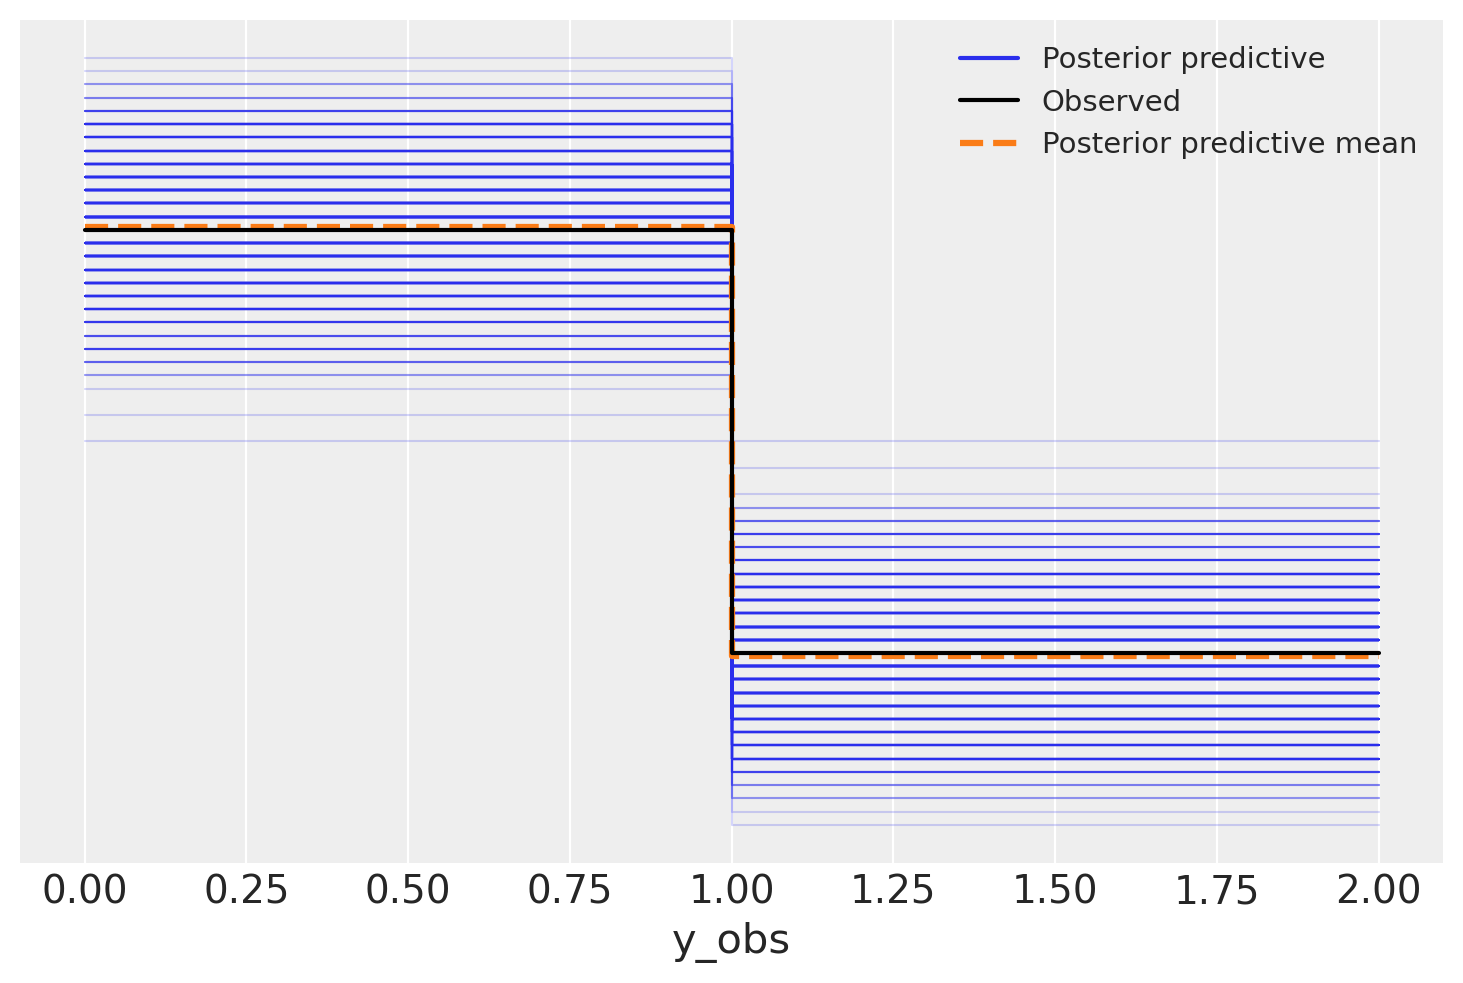

In [65]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'kde', group="posterior");

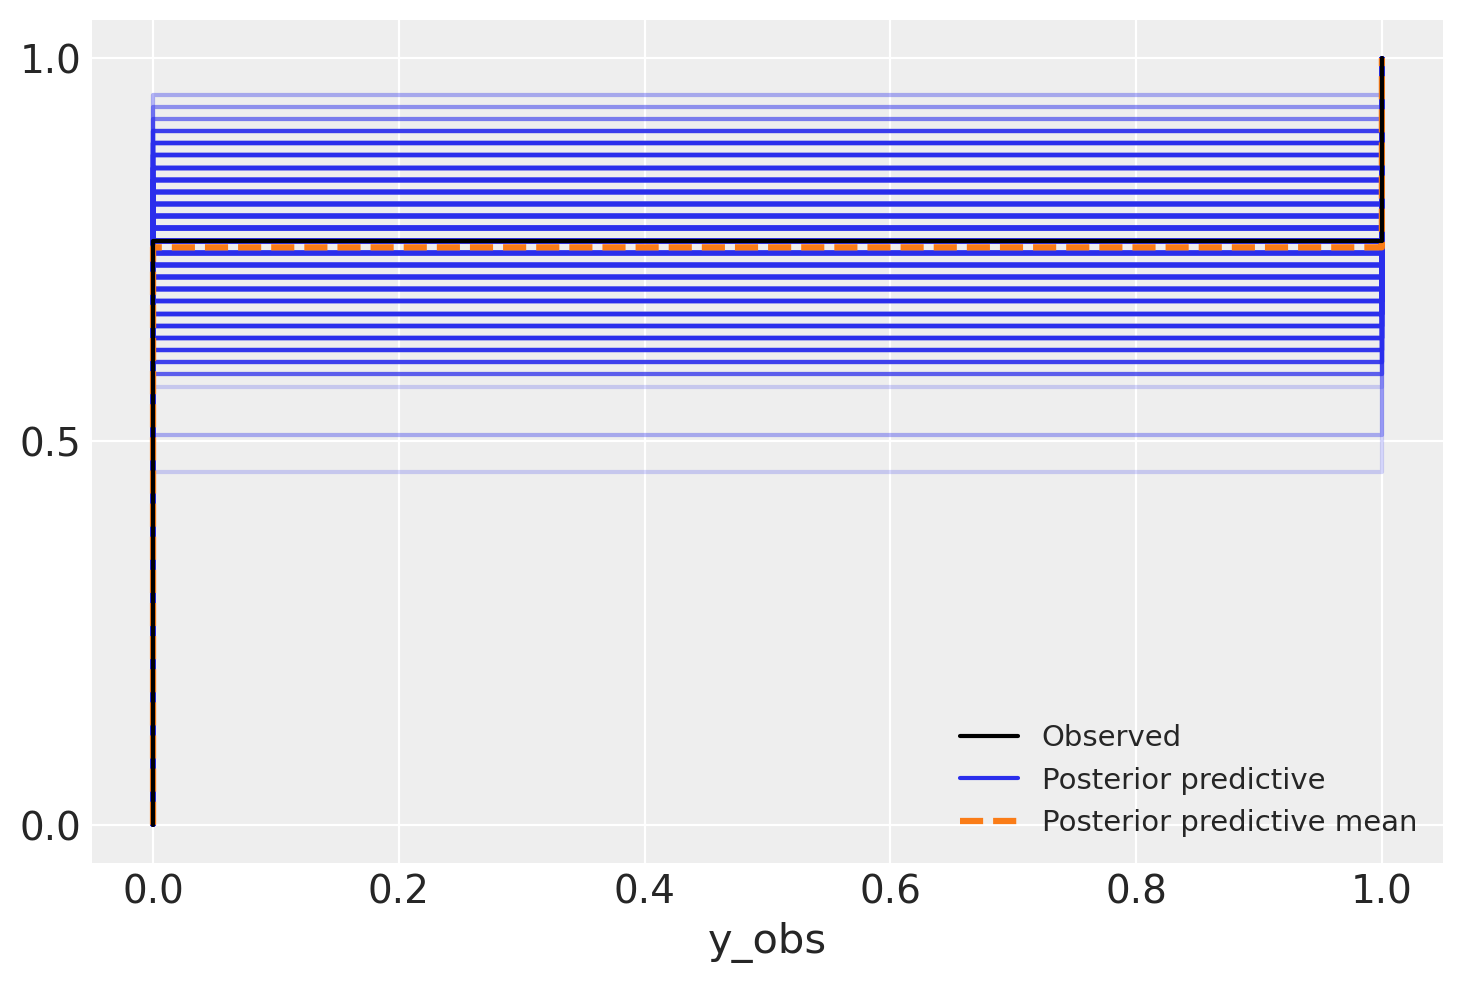

In [66]:
az.plot_ppc(trace, num_pp_samples=1000, kind = 'cumulative');

In [ ]:
az.plot_ppc(trace, num_pp_samples=5, kind = 'scatter');

In [ ]:
az.plot_autocorr(trace, var_names=["p0", "lambda"]);

In [67]:
# Gelman-Rubin convergence diagnostic
r_hat = az.rhat(trace, var_names=["p0", "lambda"])
print(r_hat)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p0       float64 1.0
    lambda   float64 1.0


In [68]:
ess = az.ess(trace, var_names=["p0", "lambda"])
ess

<xarray.Dataset>
Dimensions:  ()
Data variables:
    p0       float64 6.075e+04
    lambda   float64 6.074e+04

c:\Users\U117-T408\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:205: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_draws = data.dims["draw"]
c:\Users\U117-T408\anaconda3\envs\tf\lib\site-packages\arviz\plots\essplot.py:206: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_samples = n_draws * data.dims["chain"]


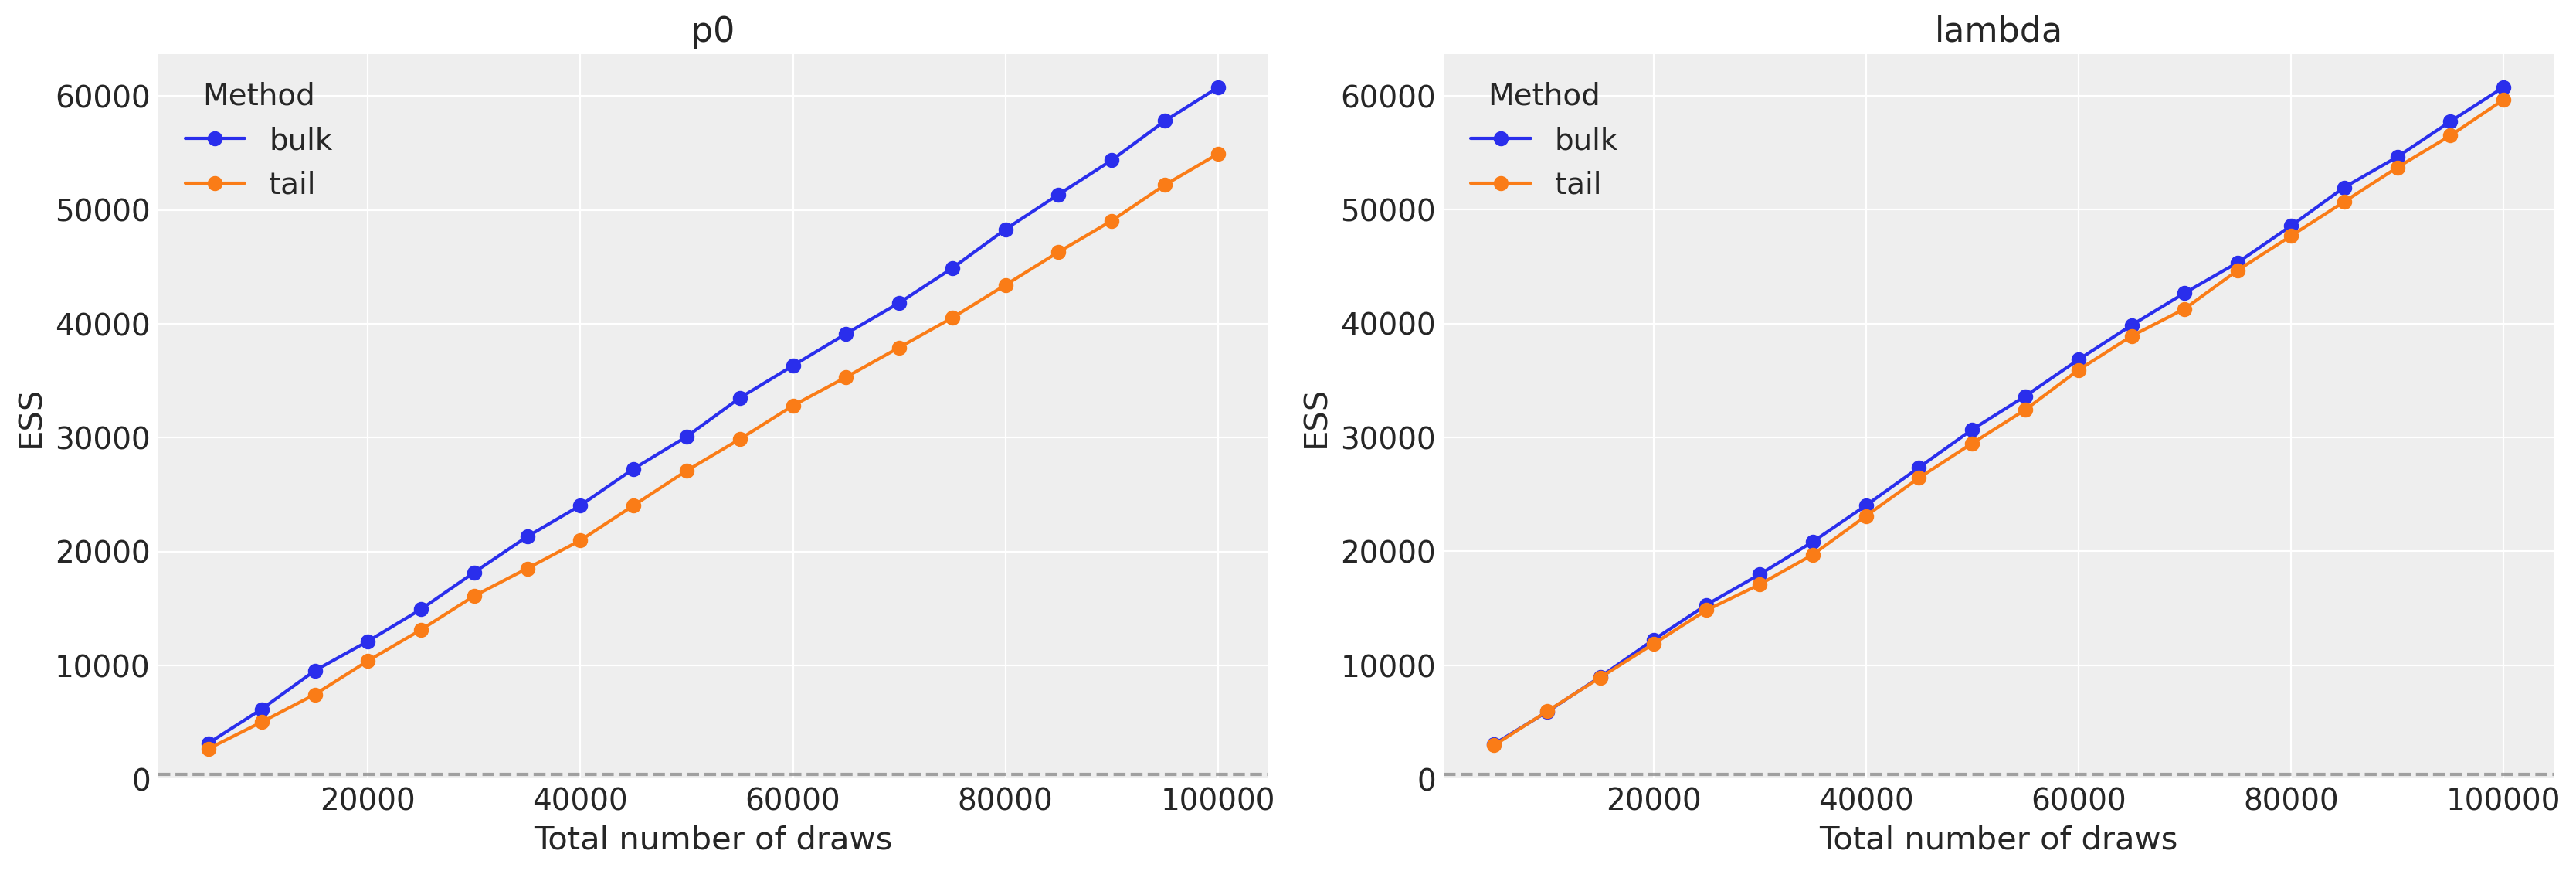

In [69]:
az.plot_ess(trace, var_names=["p0", "lambda"], kind="evolution");

In [70]:
total_ess = ess["p0"].sum().values
print(f"Total effective sample size for p0: {float(total_ess):.2f}")

Total effective sample size for p0: 60750.12


In [71]:
total_ess = ess["lambda"].sum().values
print(f"Total effective sample size for lambda: {float(total_ess):.2f}")

Total effective sample size for lambda: 60735.81
